Import libraries and read data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

C:\Users\jiaxi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('./data/preprocessed_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440384 entries, 0 to 440383
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         440384 non-null  int64  
 1   temperature        440384 non-null  float64
 2   heartrate          440384 non-null  float64
 3   resprate           440384 non-null  float64
 4   o2sat              440384 non-null  float64
 5   sbp                440384 non-null  float64
 6   dbp                440384 non-null  float64
 7   pain               440384 non-null  object 
 8   acuity             440384 non-null  float64
 9   chiefcomplaint     440367 non-null  object 
 10  gender             440384 non-null  object 
 11  race               440384 non-null  object 
 12  arrival_transport  440384 non-null  object 
 13  disposition        440384 non-null  object 
 14  arrival_hour       440384 non-null  int64  
 15  isImputed          440384 non-null  bool   
dtypes:

drop the NaN values

In [5]:
df.dropna(inplace=True)
df.isna().sum()

Unnamed: 0           0
temperature          0
heartrate            0
resprate             0
o2sat                0
sbp                  0
dbp                  0
pain                 0
acuity               0
chiefcomplaint       0
gender               0
race                 0
arrival_transport    0
disposition          0
arrival_hour         0
isImputed            0
dtype: int64

In [6]:
# removing th Unamed column collumn and count the value of acuity
df = df.drop(["Unnamed: 0"],axis = 1)
df['acuity'].value_counts()

3.0    237004
2.0    146866
4.0     30078
1.0     25253
5.0      1166
Name: acuity, dtype: int64

In [7]:
df.head()

,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,gender,race,arrival_transport,disposition,arrival_hour,isImputed
0,0.099097,0.070090,0.000988,0.010405,0.000463,0.000065,7,2.0,Hypotension,F,WHITE,AMBULANCE,HOME,16,False
1,0.099706,0.056235,0.001129,0.010405,0.000695,0.000095,0,3.0,"Abd pain, Abdominal distention",F,WHITE,AMBULANCE,ADMITTED,19,False
2,0.100720,0.084760,0.001270,0.010298,0.000695,0.000086,10,3.0,"n/v/d, Abd pain",F,WHITE,AMBULANCE,ADMITTED,20,False
3,0.100213,0.070905,0.001270,0.010405,0.000761,0.000133,10,3.0,Abdominal distention,F,WHITE,AMBULANCE,ADMITTED,15,False
4,0.100010,0.061940,0.001129,0.010513,0.000629,0.000076,13,2.0,"Abdominal distention, Abd pain, LETHAGIC",F,WHITE,AMBULANCE,ADMITTED,5,False


In [8]:
# shuffle the data and create a small batch with 10% of the full dataset
np.random.seed(112)
batch = df.sample(frac=0.1, random_state=42)

### Applying ClinicalBERT on text data

In [9]:
# Load the Bio_ClinicalBERT model via the transformers library
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model1 = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.
tokenized = batch['chiefcomplaint'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

#### Padding
After tokenization, tokenized is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). For that reason, we pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [11]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [12]:
np.array(padded).shape

(44037, 29)

#### Masking

Create another variable to tell it to ignore (mask) the padding we've added when it's processing its input.

In [13]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(44037, 29)

In [105]:
# The model1() function runs our sentences through BERT. 
# The results of the processing will be returned into last_hidden_states.

input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model1(input_ids, attention_mask=attention_mask)


In [74]:
# save those in the features variable
features = last_hidden_states[0][:,0,:].numpy()

In [75]:
# create a dataframe for text featuers
chief =  pd.DataFrame(features)

In [76]:
chief

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.311950,0.444077,-0.288557,-0.093169,-0.104896,-0.010594,0.520037,-0.435160,0.336915,0.382754,...,-0.330804,0.212703,-0.356160,0.154564,-0.123790,0.211672,0.206282,0.201522,0.277029,0.156793
1,0.687823,0.107478,-0.366926,0.276666,-0.114789,-0.040132,0.281370,-0.757352,0.556592,0.537890,...,-0.444778,0.385383,-0.204431,-0.393671,-0.158956,0.704408,0.395178,-0.272981,0.577729,-0.021654
2,0.544502,0.324034,-0.413119,-0.136429,0.048228,-0.148902,0.209255,-0.527034,0.568213,0.366345,...,-0.380303,0.159459,-0.426826,-0.022930,-0.140409,0.785520,0.114265,-0.138958,0.327461,-0.097879
3,0.515957,0.268456,-0.320933,-0.034751,-0.086898,-0.017790,0.174071,-0.270109,0.293977,0.011488,...,-0.259356,0.292617,-0.038644,-0.111788,-0.136586,0.529627,0.448041,-0.060289,0.314306,-0.122775
4,0.277032,0.495860,-0.180164,0.048023,-0.347137,-0.202029,0.023059,-0.148790,0.601625,-0.190487,...,-0.167269,0.305497,-0.104390,0.087480,-0.424541,0.386509,0.120862,-0.064220,0.686664,0.048456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44032,0.687823,0.107478,-0.366926,0.276666,-0.114789,-0.040132,0.281370,-0.757352,0.556592,0.537890,...,-0.444778,0.385383,-0.204431,-0.393671,-0.158956,0.704408,0.395178,-0.272981,0.577729,-0.021654
44033,0.180610,0.439647,-0.223505,-0.160196,-0.023676,-0.252597,0.222132,-0.092172,0.686407,0.023257,...,0.043167,0.030886,-0.167681,0.068751,-0.294101,0.371367,0.313837,0.168037,0.409323,0.079720
44034,-0.007100,0.422666,-0.359140,-0.040917,-0.195994,0.050210,0.530254,-0.123454,0.361253,-0.158439,...,-0.110313,0.201618,-0.283322,-0.067098,-0.244402,0.370745,0.125149,0.079503,0.300330,0.213981
44035,0.507366,0.087813,-0.143296,0.026168,0.202859,-0.268946,0.249754,-0.403564,0.887945,0.506444,...,0.220911,0.050108,-0.106819,0.180158,0.149701,0.421144,0.079937,0.086242,0.255107,-0.500787


### Creating target and data, and a newdf with text fearures

In [77]:
target = batch['acuity']
data = batch.drop(columns=['acuity','chiefcomplaint']) 
data = data.reset_index()
indexes = data["index"]
data.drop(columns=['index'])

new_df = pd.concat([chief,data], axis=1, join='outer')

In [78]:
target.shape

(44037,)

In [79]:
new_df.shape

(44037, 781)

In [80]:
new_df

,0,1,2,3,4,5,6,7,8,9,...,resprate,o2sat,sbp,dbp,pain,gender,race,arrival_transport,arrival_hour,isImputed
0,0.311950,0.444077,-0.288557,-0.093169,-0.104896,-0.010594,0.520037,-0.435160,0.336915,0.382754,...,0.017963,0.091381,-0.010164,-0.005026,9,M,OTHER,WALK IN,18,False
1,0.687823,0.107478,-0.366926,0.276666,-0.114789,-0.040132,0.281370,-0.757352,0.556592,0.537890,...,-0.116387,0.031585,-0.010164,-0.022496,0,F,BLACK/AFRICAN AMERICAN,WALK IN,6,False
2,0.544502,0.324034,-0.413119,-0.136429,0.048228,-0.148902,0.209255,-0.527034,0.568213,0.366345,...,-0.003723,-0.028212,0.036359,0.008561,0,F,ASIAN - CHINESE,AMBULANCE,10,True
3,0.515957,0.268456,-0.320933,-0.034751,-0.086898,-0.017790,0.174071,-0.270109,0.293977,0.011488,...,0.107530,-0.028212,-0.031311,-0.007938,5,M,WHITE - OTHER EUROPEAN,AMBULANCE,15,False
4,0.277032,0.495860,-0.180164,0.048023,-0.347137,-0.202029,0.023059,-0.148790,0.601625,-0.190487,...,0.008819,-0.042904,-0.008166,-0.005045,0,M,OTHER,AMBULANCE,7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44032,0.687823,0.107478,-0.366926,0.276666,-0.114789,-0.040132,0.281370,-0.757352,0.556592,0.537890,...,-0.071604,0.031585,0.087111,0.007591,9,M,OTHER,WALK IN,14,False
44033,0.180610,0.439647,-0.223505,-0.160196,-0.023676,-0.252597,0.222132,-0.092172,0.686407,0.023257,...,0.017963,0.091381,-0.086293,-0.001144,0,F,WHITE,WALK IN,16,False
44034,-0.007100,0.422666,-0.359140,-0.040917,-0.195994,0.050210,0.530254,-0.123454,0.361253,-0.158439,...,0.017963,-0.088008,0.142092,-0.015702,2,F,WHITE,WALK IN,0,False
44035,0.507366,0.087813,-0.143296,0.026168,0.202859,-0.268946,0.249754,-0.403564,0.887945,0.506444,...,0.376230,0.091381,0.235138,0.052235,10,M,BLACK/AFRICAN AMERICAN,WALK IN,20,False


### Logistic regressions on new_df (both tabular and text data)

In [81]:
#### getting numerical columns
numerical_col = df.select_dtypes(include=np.number).columns.tolist()
numerical_col.remove("acuity")
print('numerical_col:', numerical_col)

### text col and label
text_col = ['chiefcomplaint']
label_col = ['acuity'] 

categorical_cols =[text for text in df.columns if text not in text_col and text not in numerical_col and text not in label_col]
print('categorical_cols:', categorical_cols)

text_cols = new_df.columns[0:768]
print('text_cols:', text_cols)

numerical_col: ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'arrival_hour']
categorical_cols: ['pain', 'gender', 'race', 'arrival_transport', 'isImputed']
text_cols: Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       758, 759, 760, 761, 762, 763, 764, 765, 766, 767],
      dtype='object', length=768)


In [82]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# apply OneHotEncoder on categorical values, StandardScaler on numerical values and SimpleImputer on text data
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()
text_feature_processor = SimpleImputer(strategy="mean", add_indicator=True)

preprocessor1 = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_cols),
    ('standard_scaler', numerical_preprocessor, numerical_col)])

preprocessor2 = ColumnTransformer([('SimpleImputer', text_feature_processor, text_cols)])

In [83]:
logistic_pipeline1 = make_pipeline(preprocessor1, LogisticRegression(max_iter=500))
logistic_pipeline2 = make_pipeline(preprocessor2, LogisticRegression(max_iter=500))

In [84]:
# Combine the two pipelines to create one logistic regression
est_Ensemble = VotingClassifier(estimators = [("Tabular", logistic_pipeline1), ("Text", logistic_pipeline2)],
                                voting='soft',
                                weights=[1,1])

In [85]:
# split our datset into a training set and testing set (80% for training, 20 for testing)
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(new_df, target, random_state=42)

In [86]:
# fit the model and calculate the accuracy
est_Ensemble.fit(data_train, target_train)

VotingClassifier(estimators=[('Tabular',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('one-hot-encoder',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['pain',
                                                                                 'gender',
                                                                                 'race',
                                                                                 'arrival_transport',
                                                                                 'isImputed']),
                                                                               ('standard_scaler',
                                                                                StandardScaler(),
        

In [87]:
est_Ensemble.score(data_test, target_test)

0.667574931880109

In [88]:
# confusion matrix
label_pred = est_Ensemble.predict(data_test)
metrics = metrics.confusion_matrix(target_test, label_pred)

Text(0.5, 352.48, 'Actual label')

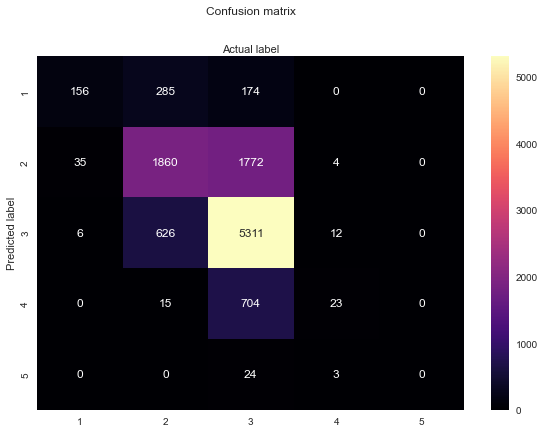

In [89]:
class_names=[1,2,3,4,5] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(metrics), annot=True,  xticklabels=class_names, yticklabels=class_names,  cmap="magma" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Predicted label')
plt.xlabel('Actual label')

In [90]:
# precision, recall and f1 score
from sklearn.metrics import classification_report
target_names = ['1','2','3','4','5']
print(classification_report(target_test, label_pred, target_names=target_names))

              precision    recall  f1-score   support

           1       0.79      0.25      0.38       615
           2       0.67      0.51      0.58      3671
           3       0.67      0.89      0.76      5955
           4       0.55      0.03      0.06       742
           5       0.00      0.00      0.00        27

    accuracy                           0.67     11010
   macro avg       0.53      0.34      0.36     11010
weighted avg       0.66      0.67      0.63     11010



In [91]:
# define a function for roc curve
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(est_Ensemble, data_train, target_train, data_test, target_test):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(est_Ensemble, encoder={1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(data_train, target_train)
    visualizer.score(data_test, target_test)
    visualizer.show()
    
    return visualizer

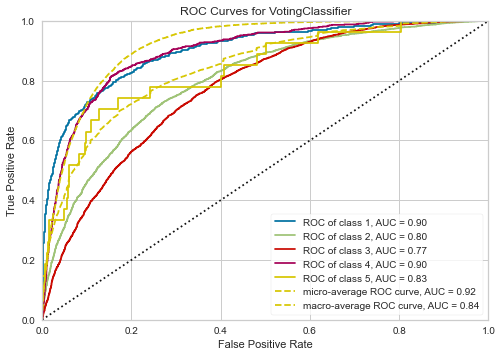

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for VotingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={1: '1', 2: '2', 3: '3', 4: '4', 5: '5'},
       estimator=VotingClassifier(estimators=[('Tabular',
                                               Pipeline(steps=[('columntransformer',
                                                                ColumnTransformer(transformers=[('one-hot-encoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                                 ['pain',...
                                                                LogisticRegression(max_iter=500))])),
                                              ('Text',
                                               Pipeline(steps=[('columntransformer',
                                                             

In [33]:
plot_ROC_curve(est_Ensemble, data_train, target_train, data_test, target_test)

### Logistic regressions on text data

In [92]:
# split text data into a training set and testing set (80% for training, 20 for testing)
train_features, test_features, train_labels, test_labels = train_test_split(features, target)

In [93]:
# create the model, fit the model and calcualte the accuracy
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.645685740236149

In [94]:
# confusion matrix
from sklearn import metrics
label_pred1 = lr_clf.predict(test_features)
metrics1 = metrics.confusion_matrix(test_labels, label_pred1)

Text(0.5, 352.48, 'Actual label')

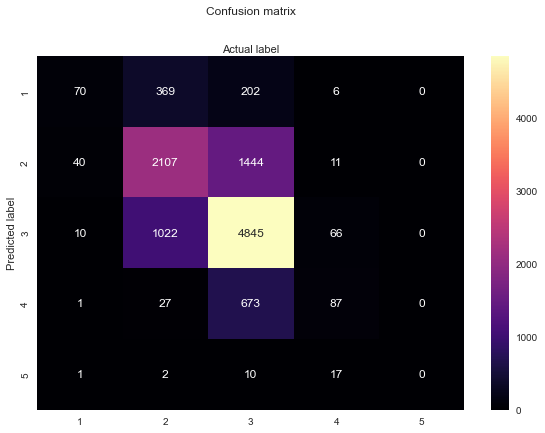

In [95]:
class_names=[1,2,3,4,5] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(metrics1), annot=True,  xticklabels=class_names, yticklabels=class_names,  cmap="magma" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Predicted label')
plt.xlabel('Actual label')

In [38]:
# precision, recall and f1 score
print(classification_report(test_labels, label_pred1, target_names=target_names))

              precision    recall  f1-score   support

           1       0.59      0.15      0.23       606
           2       0.61      0.58      0.60      3667
           3       0.68      0.82      0.74      5924
           4       0.53      0.16      0.25       795
           5       0.00      0.00      0.00        18

    accuracy                           0.65     11010
   macro avg       0.48      0.34      0.36     11010
weighted avg       0.64      0.65      0.63     11010



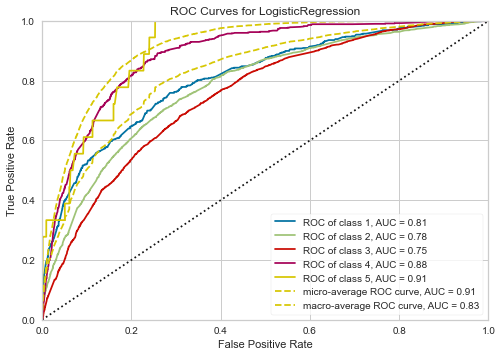

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={1: '1', 2: '2', 3: '3', 4: '4', 5: '5'},
       estimator=LogisticRegression())

In [39]:
# plot the roc curve
plot_ROC_curve(lr_clf, train_features, train_labels, test_features, test_labels)

### Logistic regressions on tabular data

In [96]:
# As we already created a pipeline for tabular data, we use it here for model training
logistic_pipeline1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pain', 'gender', 'race',
                                                   'arrival_transport',
                                                   'isImputed']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['temperature', 'heartrate',
                                                   'resprate', 'o2sat', 'sbp',
                                                   'dbp', 'arrival_hour'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [97]:
# split tabular data into a training set and testing set (80% for training, 20 for testing)
data_train, data_test, target_train, target_test = train_test_split(data, target, random_state=42)

In [98]:
# fit the model and calcualte the accuracy
_ = logistic_pipeline1.fit(data_train, target_train)
logistic_pipeline1.score(data_test, target_test)

0.596094459582198

In [99]:
# confusion matrix
label_pred2 = logistic_pipeline1.predict(data_test)
metrics2 = metrics.confusion_matrix(target_test, label_pred2)

Text(0.5, 352.48, 'Actual label')

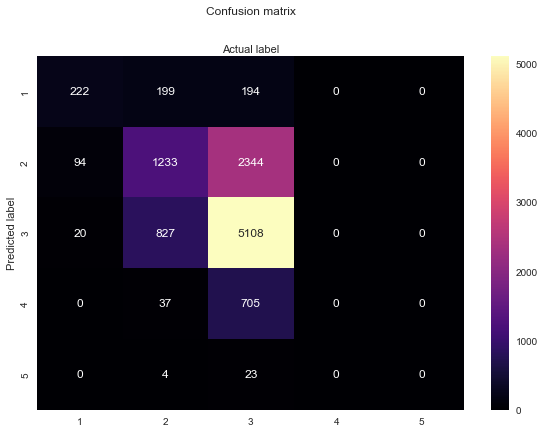

In [100]:
class_names=[1,2,3,4,5] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(metrics2), annot=True,  xticklabels=class_names, yticklabels=class_names, cmap="magma" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Predicted label')
plt.xlabel('Actual label')

In [45]:
# precision, recall and f1 score
print(classification_report(target_test, label_pred2, target_names=target_names))

              precision    recall  f1-score   support

           1       0.66      0.36      0.47       615
           2       0.54      0.34      0.41      3671
           3       0.61      0.86      0.71      5955
           4       0.00      0.00      0.00       742
           5       0.00      0.00      0.00        27

    accuracy                           0.60     11010
   macro avg       0.36      0.31      0.32     11010
weighted avg       0.55      0.60      0.55     11010



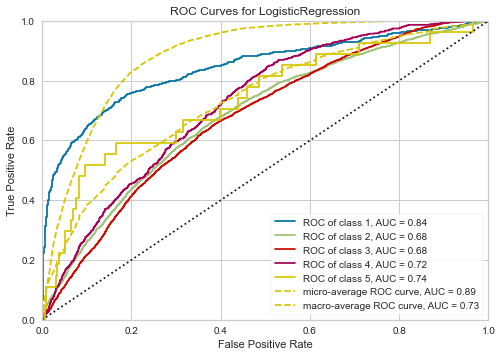

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={1: '1', 2: '2', 3: '3', 4: '4', 5: '5'},
       estimator=Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('one-hot-encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['pain',
                                                                    'gender',
                                                                    'race',
                                                                    'arrival_transport',
                                                                    'isImputed']),
                                                                  ('standard_scaler',
                                                                   Sta

In [46]:
# plot the roc curve
plot_ROC_curve(logistic_pipeline1, data_train, target_train, data_test, target_test)

### Read the logistic regression model on new_df (both tabular data and text data) and load it

In [47]:
import pickle
# save the model to a file
with open('LogisticRegression.pkl', 'wb') as f:
    pickle.dump(est_Ensemble, f)

In [144]:
# load the model
with open('LogisticRegression.pkl', 'rb') as f:
    model_read = pickle.load(f)

In [145]:
print(model_read)

VotingClassifier(estimators=[('Tabular',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('one-hot-encoder',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['pain',
                                                                                 'gender',
                                                                                 'race',
                                                                                 'arrival_transport',
                                                                                 'disposition',
                                                                                 'isImputed']),
                                                                               ('standard_scaler',
          